In [ ]:
# Step 1: Install required libraries
!pip install pymupdf faiss-cpu sentence-transformers streamlit networkx pyvis pytesseract pillow pdf2image transformers accelerate sentencepiece
!apt-get install -y poppler-utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.10 [186 kB]
Fetched 186 kB in 0s (1,674 kB/s)
Selecting previously unselected package poppler-utils.
(

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget -O transformer.pdf https://arxiv.org/pdf/1706.03762.pdf


--2025-09-26 16:16:03--  https://arxiv.org/pdf/1706.03762.pdf
Resolving arxiv.org (arxiv.org)... 151.101.67.42, 151.101.195.42, 151.101.131.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.67.42|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /pdf/1706.03762 [following]
--2025-09-26 16:16:03--  https://arxiv.org/pdf/1706.03762
Reusing existing connection to arxiv.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 2215244 (2.1M) [application/pdf]
Saving to: ‘transformer.pdf’

transformer.pdf     100%[===================>]   2.11M  --.-KB/s    in 0.03s   

2025-09-26 16:16:03 (78.6 MB/s) - ‘transformer.pdf’ saved [2215244/2215244]



In [ ]:
import shutil

# Create folder if it doesn’t exist
!mkdir -p /content/drive/MyDrive/ResearchPapers

# Move the file
shutil.move("transformer.pdf", "/content/drive/MyDrive/ResearchPapers/transformer.pdf")


'/content/drive/MyDrive/ResearchPapers/transformer.pdf'

In [ ]:
# Step 2: PDF parsing + OCR fallback
import fitz  # PyMuPDF
import pytesseract
from pdf2image import convert_from_path
from PIL import Image

# Function to extract text normally
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text("text") + "\n"
    return text

# OCR function for scanned PDFs
def extract_text_with_ocr(pdf_path):
    pages = convert_from_path(pdf_path, dpi=300)
    text = ""
    for page_num, page in enumerate(pages, 1):
        text += pytesseract.image_to_string(page) + "\n"
        print(f"OCR processed page {page_num}/{len(pages)}")
    return text

# Smart extractor: normal first, OCR fallback if needed
def smart_extract_text(pdf_path):
    text = extract_text_from_pdf(pdf_path)
    if len(text.strip()) < 100:  # too little text → scanned
        print("⚠️ Low text detected. Switching to OCR...")
        text = extract_text_with_ocr(pdf_path)
    return text

# Extract text from your PDF
pdf_path = "/content/drive/MyDrive/ResearchPapers/transformer.pdf"  # replace with any PDF
raw_text = smart_extract_text(pdf_path)
print(raw_text[:1000])  # preview first 1000 characters


Provided proper attribution is provided, Google hereby grants permission to
reproduce the tables and figures in this paper solely for use in journalistic or
scholarly works.
Attention Is All You Need
Ashish Vaswani∗
Google Brain
avaswani@google.com
Noam Shazeer∗
Google Brain
noam@google.com
Niki Parmar∗
Google Research
nikip@google.com
Jakob Uszkoreit∗
Google Research
usz@google.com
Llion Jones∗
Google Research
llion@google.com
Aidan N. Gomez∗†
University of Toronto
aidan@cs.toronto.edu
Łukasz Kaiser∗
Google Brain
lukaszkaiser@google.com
Illia Polosukhin∗‡
illia.polosukhin@gmail.com
Abstract
The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks that include an encoder and a decoder. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer,
based solely on attention mechanisms, dispensing with recurrence and convolutions
entirely. Exper

In [ ]:
# Step 3: Sanity check
num_chars = len(raw_text)
num_words = len(raw_text.split())
num_pages = raw_text.count("\f")  # page breaks sometimes marked as \f

print(f"Characters extracted: {num_chars}")
print(f"Words extracted: {num_words}")
print(f"Approx Pages Detected: {num_pages if num_pages > 0 else 'Not detected'}")


Characters extracted: 39513
Words extracted: 6095
Approx Pages Detected: Not detected


In [ ]:
# Step 4: Refined Section-aware Text Chunking
import re

def split_into_chunks(text):
    section_headers = [
        "ABSTRACT", "INTRODUCTION", "RELATED WORK", "METHODOLOGY", "METHOD",
        "RESULTS", "DISCUSSION", "CONCLUSION", "ACKNOWLEDGEMENT", "ACKNOWLEDGEMENTS",
        "REFERENCES", "CHAPTER"
    ]

    lines = text.split("\n")
    sections = {}
    current_section = "GENERAL"
    buffer = []

    for line in lines:
        line_stripped = line.strip().upper()

        # Match exact section headers
        if line_stripped in section_headers or any(line_stripped.startswith(h) for h in section_headers):
            if buffer:
                sections[current_section] = sections.get(current_section, []) + ["\n".join(buffer).strip()]
                buffer = []
            current_section = line_stripped  # recognized section
        else:
            buffer.append(line)

    if buffer:
        sections[current_section] = sections.get(current_section, []) + ["\n".join(buffer).strip()]

    # Build chunks list
    chunks, chunk_sections = [], []
    for sec, paras in sections.items():
        for i, content in enumerate(paras):
            if content:
                chunks.append(content)
                chunk_sections.append(f"{sec}_P{i+1}")

    return chunks, chunk_sections

# Apply to raw text
chunks, chunk_sections = split_into_chunks(raw_text)

print(f"Total chunks: {len(chunks)}")
print("Preview:", list(zip(chunk_sections[:3], [c[:120] for c in chunks[:3]])))

Total chunks: 8
Preview: [('GENERAL_P1', 'Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this pap'), ('ABSTRACT_P1', 'The dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include a'), ('INTRODUCTION_P1', 'Recurrent neural networks, long short-term memory [13] and gated recurrent [7] neural networks\nin particular, have been ')]


In [ ]:
# Step 5: Embeddings + FAISS index
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

# Load embedding model
embed_model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode chunks
embeddings = embed_model.encode(chunks, convert_to_numpy=True)

print("Embedding shape:", embeddings.shape)  # (num_chunks, embedding_dim)

# Create FAISS index
dim = embeddings.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings)
print("FAISS index size:", index.ntotal)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding shape: (8, 384)
FAISS index size: 8


In [ ]:
# Step 6: FAISS Search with Scores
import numpy as np
import faiss

# Ensure embeddings are ready from Step 5
dim = embeddings.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings)

print("FAISS index size:", index.ntotal)

# Store sections + chunks for retrieval
chunk_texts = [c for c in chunks]   # original text
chunk_sections = [c.split("\n", 1)[0] if "\n" in c else "GENERAL" for c in chunks]

def search_faiss_with_scores(query, top_k=5):
    query_vec = embed_model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_vec, top_k)

    results, scores, metadata = [], [], []
    for i, idx in enumerate(indices[0]):
        if idx == -1:
            continue
        results.append(chunk_texts[idx])
        scores.append(float(distances[0][i]))
        metadata.append(chunk_sections[idx])
    return results, scores, metadata



FAISS index size: 8


In [ ]:
import re
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# --- Load Flan-T5 for Q&A ---
flan_name = "google/flan-t5-base"
flan_tokenizer = AutoTokenizer.from_pretrained(flan_name)
flan_model = AutoModelForSeq2SeqLM.from_pretrained(flan_name)

# --- Load BART for summarization ---
bart_name = "facebook/bart-large-cnn"
bart_tokenizer = AutoTokenizer.from_pretrained(bart_name)
bart_model = AutoModelForSeq2SeqLM.from_pretrained(bart_name)

# --- Summarization with BART ---
def summarize_with_bart(text, max_tokens=150):
    """Summarize long text using BART"""
    inputs = bart_tokenizer([text], return_tensors="pt", truncation=True, max_length=1024)
    summary_ids = bart_model.generate(
        inputs["input_ids"],
        attention_mask=inputs.get("attention_mask", None),
        max_length=max_tokens,
        min_length=50,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )
    return bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# --- QA with Flan-T5 ---
def answer_with_flan(question, candidate_chunks, sections, max_tokens=200):
    """Flan-T5 uses retrieved passages to answer, keeps section traceability"""
    # keep section traceability in context
    context = "\n\n".join([f"[{sections[i]}] {c}" for i, c in enumerate(candidate_chunks)])

    prompt = f"""
You are a helpful research assistant.
Below are passages retrieved from different sections of a research paper.
Use only the relevant passages to answer.
Also mention which section(s) the answer is based on.

Passages:
{context}

Question: {question}
Answer (with section references):
"""
    inputs = flan_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024)
    output = flan_model.generate(
        **inputs,
        max_new_tokens=max_tokens,
        num_beams=4,
        early_stopping=True
    )
    return flan_tokenizer.decode(output[0], skip_special_tokens=True)

# --- Section-aware Router ---
def answer_question_hybrid(question, top_k=10):
    """
    Main router: routes question to summary / metrics / methodology / refs / qa
    Assumes a function `search_faiss_with_scores(question, top_k)` exists and returns:
      results: list of text snippets (strings)
      scores: list of floats
      metadata: list of section names or other metadata (strings)
    """
    q_l = question.lower()

    # --- Section routing ---
    if any(x in q_l for x in ["summarize", "abstract", "conclusion", "overview"]):
        section_filter, mode = ["ABSTRACT", "CONCLUSION"], "summary"
    elif any(x in q_l for x in ["accuracy", "results", "performance", "evaluation", "bleu", "f1", "precision", "recall", "rouge", "score"]):
        section_filter, mode = ["RESULTS", "EXPERIMENTS", "EVALUATION", "ANALYSIS"], "metrics"
    elif any(x in q_l for x in ["method", "methodology", "approach", "proposed", "architecture", "framework", "model"]):
        section_filter, mode = ["METHOD", "METHODOLOGY", "MODEL", "APPROACH", "PROPOSED"], "methodology"
    elif any(x in q_l for x in ["introduction", "background", "related work"]):
        section_filter, mode = ["INTRODUCTION", "RELATED WORK", "BACKGROUND"], "qa"
    elif any(x in q_l for x in ["reference", "bibliography", "citation"]):
        section_filter, mode = ["REFERENCES", "BIBLIOGRAPHY"], "refs"
    else:
        section_filter, mode = [], "qa"

    # --- Retrieve passages (user must provide search_faiss_with_scores) ---
    results, scores, metadata = search_faiss_with_scores(question, top_k=top_k)

    if not results:
        return "No relevant passages found."

    if section_filter:
        filtered = [(r, m) for r, m in zip(results, metadata) if any(sf in m.upper() for sf in section_filter)]
        if filtered:
            results, metadata = zip(*filtered)
        results, metadata = list(results), list(metadata)
    else:
        results, metadata = list(results), list(metadata)

    # --- Handle modes ---
    if mode == "summary":
        return summarize_with_bart(" ".join(results[:top_k]))

    elif mode == "metrics":
        context = " ".join(results)
        pattern = re.compile(r"(\d+(?:\.\d+)?)\s*(BLEU|accuracy|f1|precision|recall|rouge|%|percent)\b", flags=re.I)
        out = []
        bleu_dict = {"EN-DE": [], "EN-FR": [], "GENERIC": []}
        other_metrics = []

        for m in pattern.finditer(context):
            val = m.group(1)
            metric = m.group(2).lower()

            # --- BLEU special handling ---
            if metric == "bleu":
                surrounding = context[max(0, m.start() - 200): m.end() + 200]
                if re.search(r"en[- _]?de|english.*german|english-to-german|wmt.*german", surrounding, re.I):
                    bleu_dict["EN-DE"].append(val)
                elif re.search(r"en[- _]?fr|english.*french|english-to-french|wmt.*french", surrounding, re.I):
                    bleu_dict["EN-FR"].append(val)
                else:
                    bleu_dict["GENERIC"].append(val)
            else:
                other_metrics.append(f"{val} {metric.upper()}")

        # --- Format BLEU nicely ---
        bleu_out = []
        for lang, vals in bleu_dict.items():
            if vals:
                if lang == "GENERIC":
                    bleu_out.append("BLEU = " + ", ".join(vals))
                else:
                    bleu_out.append(f"{lang} = " + ", ".join(vals) + " BLEU")

        # --- Combine everything ---
        final = bleu_out + other_metrics

        if final:
            return "Reported metrics (from RESULTS section): " + " | ".join(final)
        else:
            return answer_with_flan(question, results, metadata)

    elif mode == "methodology":
        full_text = " ".join(results[:top_k])
        match = re.search(
            r"(?:^|\n)\s*(Methodology|Model|Approach|Architecture|Method|Proposed)(.*?)(?:\n\s*(Results|Experiments|Evaluation|Conclusion|References)\b)",
            full_text,
            re.S | re.I
        )
        if match:
            methodology_text = match.group(2)
            methodology_text = re.sub(r"^[^A-Za-z]+", "", methodology_text).strip()
            methodology_text = methodology_text[:8000]
            return summarize_with_bart(methodology_text, max_tokens=200)
        else:
            return summarize_with_bart(" ".join(results[:min(len(results), 6)]), max_tokens=200)

    elif mode == "refs":
        # --- Collect potential references ---
        joined_refs = "\n".join(results[:min(len(results), 50)])
        merged = re.sub(r"\n\s+", " ", joined_refs)  # merge broken lines

        # Split by markers: [number], numbered lists, or line breaks
        candidates = re.split(r"(?:\[\d+\]|\n\d+\.|\n)", merged)

        refs = []
        for c in candidates:
            line = c.strip()
            if not line:
                continue
            if re.search(r"\b\d{4}\b", line) and len(line.split()) > 4:
                refs.append(line)
            elif re.search(r"(arxiv|iclr|nips|neurips|acl|cvpr|icml|emnlp)", line, re.I):
                refs.append(line)

        # Fallback: if strict filter failed, take first 10 non-empty lines
        if not refs:
            fallback = [c.strip() for c in candidates if c.strip()]
            refs = fallback[:10]

        top_refs = refs[:10]
        numbered = [f"[{i+1}] {ref}" for i, ref in enumerate(top_refs)]
        return "Top references:\n" + "\n".join(numbered)

    else:
        return answer_with_flan(question, results, metadata)


# -------------------------
print("🤖 Hello!! I am your research assistant. Upload any research paper and ask questions.")


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

🤖 Hello!! I am your research assistant. Upload any research paper and ask questions.


In [ ]:
queries = [
    "What is the attention mechanism?",
    "Summarize the abstract",
    "What is the model accuracy or BLEU score reported in this paper?",
    "Explain the methodology in 3-4 sentences.",
    "Give me the main conclusion of the paper",
    "Show me the references"
]


In [ ]:
# -------------------------
# 🔍 Example Queries to test modes
# -------------------------

# 1. General QA
q1 = "What is the attention mechanism?"
ans1 = answer_question_hybrid(q1, top_k=10)
print("\nQ:", q1, "\nA:", ans1)

# 2. Summarization
q2 = "Summarize the abstract"
ans2 = answer_question_hybrid(q2, top_k=10)
print("\nQ:", q2, "\nA:", ans2)

# 3. Accuracy / Performance
q3 = "What is the model accuracy or BLEU score reported in this paper?"
ans3 = answer_question_hybrid(q3, top_k=10)
print("\nQ:", q3, "\nA:", ans3)

# 4. Methodology
q4 = "Explain the methodology in 3-4 sentences."
ans4 = answer_question_hybrid(q4, top_k=10)
print("\nQ:", q4, "\nA:", ans4)

# 5. Conclusion
q5 = "Give me the main conclusion of the paper"
ans5 = answer_question_hybrid(q5, top_k=10)
print("\nQ:", q5, "\nA:", ans5)

# 6. References
q6 = "Show me the references"
ans6 = answer_question_hybrid(q6, top_k=10)
print("\nQ:", q6, "\nA:\n", ans6)



Q: What is the attention mechanism? 
A: In this work we presented the Transformer, the first sequence transduction model based entirely on attention, replacing the recurrent layers most commonly used in encoder-decoder architectures with multi-headed self-attention

Q: Summarize the abstract 
A: Researchers have been working on deep neural networks for machine translation. They have also been exploring the limits of language modeling. Their work has been published in the open-access journal arXiv and the journal of the Association for Computing Machinery (ACM)

Q: What is the model accuracy or BLEU score reported in this paper? 
A: Reported metrics (from RESULTS section): EN-DE = 2.0 BLEU | EN-FR = 28.4, 2 BLEU | BLEU = 0.9 | 23 F1

Q: Explain the methodology in 3-4 sentences. 
A: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. We propose a new simple network architecture, the Transformer,

In [ ]:
# Step 8: Save FAISS index, embeddings, chunks, and metadata to Google Drive
import pickle
import numpy as np
import os

save_path = "/content/drive/MyDrive/research_chatbot/transformer"
os.makedirs(save_path, exist_ok=True)

# Save FAISS index
faiss.write_index(index, f"{save_path}/faiss.index")

# Save embeddings
np.save(f"{save_path}/embeddings.npy", embeddings)

# Save chunks
with open(f"{save_path}/chunks.pkl", "wb") as f:
    pickle.dump(chunks, f)

# Save metadata (section labels)
with open(f"{save_path}/metadata.pkl", "wb") as f:
    pickle.dump(chunk_sections, f)

print("✅ Saved FAISS index, embeddings, chunks, and metadata to Google Drive")


✅ Saved FAISS index, embeddings, chunks, and metadata to Google Drive


In [ ]:
# Step 9: Load FAISS index, embeddings, chunks, and metadata from Google Drive
import pickle
import numpy as np

load_path = "/content/drive/MyDrive/research_chatbot/transformer"

# Load FAISS index
index = faiss.read_index(f"{load_path}/faiss.index")

# Load embeddings
embeddings = np.load(f"{load_path}/embeddings.npy")

# Load chunks
with open(f"{load_path}/chunks.pkl", "rb") as f:
    chunks = pickle.load(f)

    # Load metadata
with open(f"{load_path}/metadata.pkl", "rb") as f:
    metadata = pickle.load(f)

print("✅ Loaded FAISS index, embeddings, chunks, and metadata from Google Drive")
print("Total chunks loaded:", len(chunks))
print("Metadata sample:", metadata[:5])


✅ Loaded FAISS index, embeddings, chunks, and metadata from Google Drive
Total chunks loaded: 8
Metadata sample: ['Provided proper attribution is provided, Google hereby grants permission to', 'The dominant sequence transduction models are based on complex recurrent or', 'Recurrent neural networks, long short-term memory [13] and gated recurrent [7] neural networks', '6.1', '6.3']


In [ ]:
# Step 10: Save and Load Graph for Visualization
import networkx as nx
import pickle

# --- Create a knowledge graph with section labels ---
def build_graph_with_sections(chunks, chunk_sections):
    G = nx.Graph()
    for i, (chunk, label) in enumerate(zip(chunks, chunk_sections)):
        G.add_node(
            f"Chunk {i+1}",
            text=chunk[:150],   # store first 150 chars for preview
            label=label         # store section label (ABSTRACT, INTRO, etc.)
        )
        if i > 0:  # link sequential chunks
            G.add_edge(f"Chunk {i}", f"Chunk {i+1}")
    return G

# Build graph
graph = build_graph_with_sections(chunks, chunk_sections)

# Save graph
with open(f"{save_path}/graph.pkl", "wb") as f:   # use save_path (not load_path)
    pickle.dump(graph, f)

print("✅ Graph saved to Google Drive")

# Load graph (when needed later)
with open(f"{save_path}/graph.pkl", "rb") as f:
    loaded_graph = pickle.load(f)

print("✅ Graph loaded with", len(loaded_graph.nodes), "nodes and", len(loaded_graph.edges), "edges")

✅ Graph saved to Google Drive
✅ Graph loaded with 8 nodes and 7 edges


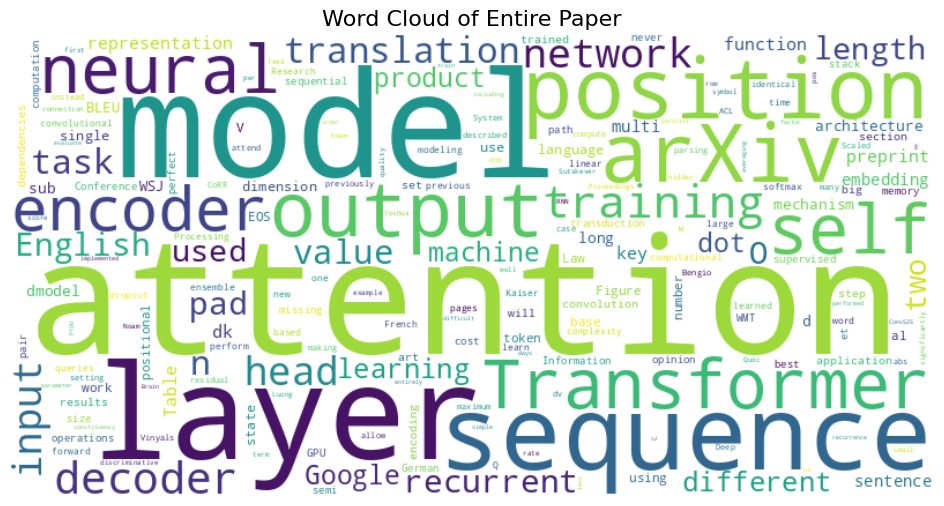

In [ ]:
# Word Cloud of Entire Paper + Section-wise (fixed)
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(chunks, metadata, section=None):
    if section:
        # Match section names flexibly (e.g., "ABSTRACT" matches "ABSTRACT_P1")
        section_texts = [c for c, m in zip(chunks, metadata) if section.upper() in m]
        if not section_texts:
            print(f"No chunks found for section: {section}")
            return
        text = " ".join(section_texts)
        title = f"Word Cloud - {section.upper()}"
    else:
        # All chunks combined
        text = " ".join(chunks)
        title = "Word Cloud of Entire Paper"

    # Generate word cloud
    wc = WordCloud(width=800, height=400, background_color="white",
                   colormap="viridis", collocations=False).generate(text)

    # Plot
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Example usage
plot_wordcloud(chunks, chunk_sections)             # whole paper

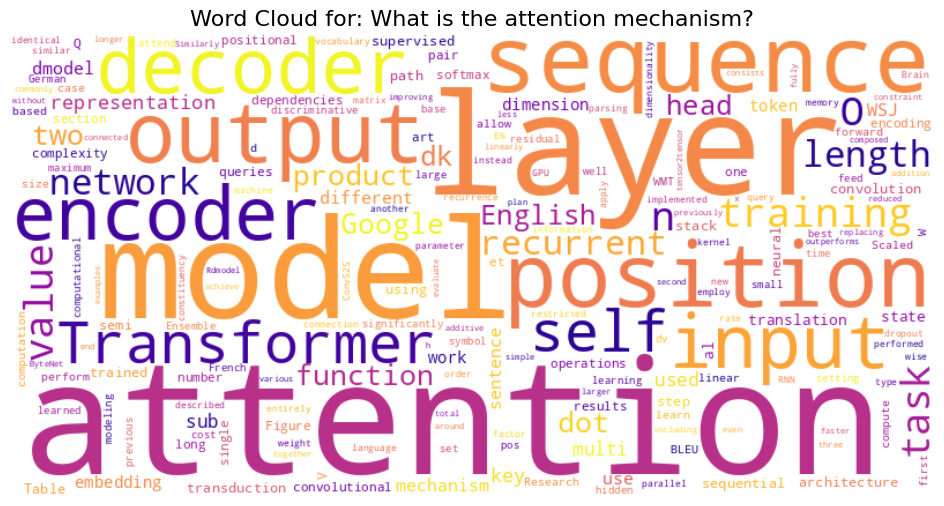

In [ ]:
# Word Cloud of Entire Paper
def plot_wordcloud_for_question(question, top_k=5):
    results, scores, metadata = search_faiss_with_scores(question, top_k=top_k)
    text = " ".join(results)
    wc = WordCloud(width=800, height=400, background_color="white",
                   colormap="plasma", collocations=False).generate(text)

    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for: {question}", fontsize=16)
    plt.show()

# Example usage
plot_wordcloud_for_question("What is the attention mechanism?")


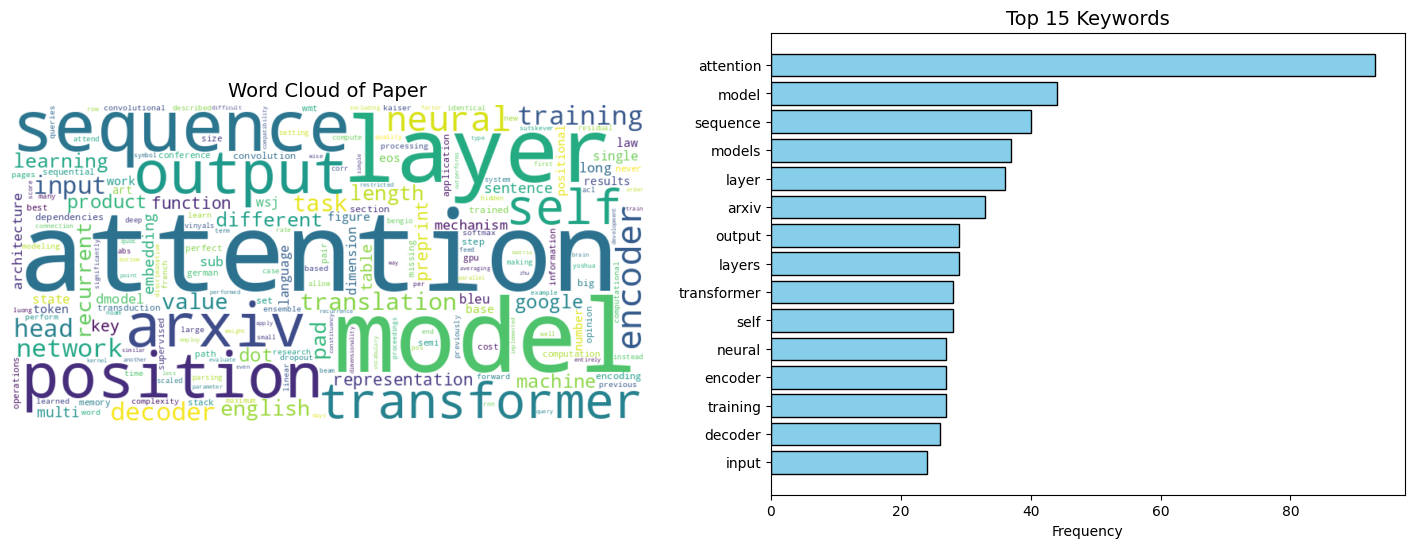

In [ ]:
# 📊 Final Visualization Section
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re

def plot_wordcloud_and_keywords(chunks, top_n=15):
    # Combine all text
    text = " ".join(chunks).lower()

    # Basic cleaning
    words = re.findall(r"\b[a-z]{3,}\b", text)  # only words >=3 chars
    stopwords = {"the","and","for","that","with","this","from","are","was","were",
                 "have","has","had","but","not","can","will","use","used","using",
                 "into","such","also","these","those","our","their","which","one",
                 "two","three","when","then","than","been","they","his","her","its"}
    words = [w for w in words if w not in stopwords]

    # Count frequencies
    counter = Counter(words)
    common_words = counter.most_common(top_n)

    # --- Word Cloud ---
    wc = WordCloud(width=800, height=400, background_color="white",
                   colormap="viridis", collocations=False).generate(" ".join(words))

    # --- Plot ---
    fig, axes = plt.subplots(1, 2, figsize=(18,6))

    # Left: Word Cloud
    axes[0].imshow(wc, interpolation="bilinear")
    axes[0].axis("off")
    axes[0].set_title("Word Cloud of Paper", fontsize=14)

    # Right: Bar Chart of Top Keywords
    words_list, freq_list = zip(*common_words)
    axes[1].barh(words_list[::-1], freq_list[::-1], color="skyblue", edgecolor="black")
    axes[1].set_title(f"Top {top_n} Keywords", fontsize=14)
    axes[1].set_xlabel("Frequency")

    plt.show()

# Example usage
plot_wordcloud_and_keywords(chunks, top_n=15)
